In [37]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output
import textwrap

In [38]:
df = pd.read_excel('data.xlsx', sheet_name='Sheet1')
df2 = pd.read_excel('data.xlsx', sheet_name='Sheet2')
df3 = pd.read_excel('data.xlsx', sheet_name='Sheet3')
df = df.rename(columns={'Unnamed: 0' : 'State', 'Average of Denial_Rate' : '% of Claims Denied'})
df = df.round({'Average of Denial_Rate': 2})
df2 = df2.rename(columns=lambda x: x.strip())
df2 = df2.rename(columns = {'Number_Internal_Appeals_Overturned' : 'Overturned Appeals','Internal_Appeals_Upheld' : 'Upheld Appeals'})
df3 = df3.rename(columns=lambda x: x.strip())

In [39]:
states = gpd.read_file("states.shp")
def choropleth_plot():
    fig = px.choropleth(df,
                    locations=df['State'],
                    locationmode="USA-states",
                    color=df['% of Claims Denied'] * 100,
                    color_continuous_scale="Viridis",
                    scope="usa",
                    title='Denial Rate of Claims Per State (%) (2023)')
    fig.add_annotation(
      text="Centers for Medicare & Medicaid Services,  \"Transparency in Coverage PUF (TC-PUF)\", 2023, <br> \
      https://www.cms.gov/marketplace/resources/data/public-use-files",
      xref="paper", yref="paper",
      x=0.75, y=-0.1,
      showarrow=False,
      xanchor="right", yanchor="bottom")
    fig.update_layout(title = {'x': 0.25, 'y': 0.95},
                      margin = dict(t=50, r=25,  l=25))
    return fig

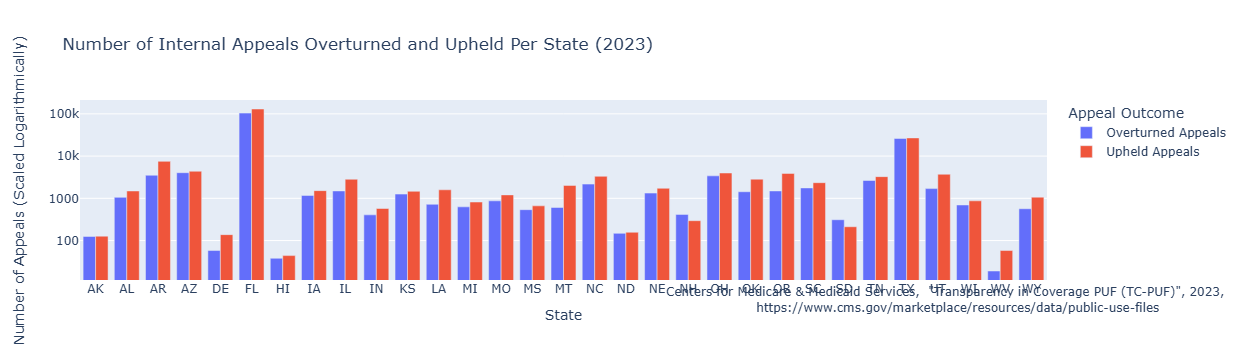

In [40]:
df2_melted = pd.melt(df2, id_vars=['State'],
                     value_vars=['Overturned Appeals', 'Upheld Appeals'],
                     var_name='Appeal Outcome', value_name='Count')
fig2 = px.bar(
    df2_melted,
    x="State",
    y="Count",
    log_y=True,
    labels={'Count': 'Number of Appeals (Scaled Logarithmically)'},
    color="Appeal Outcome",
    color_continuous_scale='Viridis',
    barmode="group",
    title="Number of Internal Appeals Overturned and Upheld Per State (2023)"
    )
fig2.add_annotation(
    text="Centers for Medicare & Medicaid Services,  \"Transparency in Coverage PUF (TC-PUF)\", 2023, <br> \
    https://www.cms.gov/marketplace/resources/data/public-use-files",
    xref="paper", yref="paper",
    x=1.19, y=-0.2,
    showarrow=False,
    xanchor="right", yanchor="bottom" )
fig2.show()

In [54]:
def wrap_labels(labels, width=20):
    return ['<br>'.join(textwrap.wrap(label, width=width)) for label in labels]
def treemap_plot(state):
    state_data = df3[df3['State'] == state].iloc[:, 1:]
    state_data.columns = wrap_labels(state_data.columns)
    other = state_data.pop('Other')
    other_percent = int((other / (state_data.sum().sum() + other)*100).iloc[0])
    flat_data = state_data.values.flatten().tolist()
    flat_data = [1 if x == 0 else x for x in flat_data]
    fig = px.treemap(state_data,
                    path=[state_data.columns],
                    values=flat_data,
                    color=flat_data,
                    color_continuous_scale='PuBu',
                    title=f'Reasons for Claim Denials in {state}')
    fig.data[0].textinfo = 'label+percent parent'
    fig.add_annotation(
      text=f'Other accounts for {other_percent}% of denial reasons',
      x=0, y=1.10,
      showarrow=False)
    fig.update_layout(uniformtext=dict(minsize=15, mode='hide'),)
    fig.update(layout_coloraxis_showscale=False)
    fig.add_annotation(
    text="Centers for Medicare & Medicaid Services, \"Transparency in Coverage PUF (TC-PUF)\", 2023, <br>\
    https://www.cms.gov/marketplace/resources/data/public-use-files",
    xref="paper", yref="paper",
    x=0.75, y=-0.2,
    showarrow=False,
    xanchor="right", yanchor="bottom" )
    return fig

In [52]:
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
app.layout = dbc.Container([
    dbc.Card([
            dbc.Button('🡠',
                       id='back-button',
                       outline=True,
                       size="sm",
                       className='mt-2 ml-2 col-1',
                       style={'display': 'none'}
                       ),
            dbc.Row(
                dcc.Graph(
                        id='graph',
                        figure=choropleth_plot()
                        ),
                justify='center'
            )
            ], className='mt-3')
])

@app.callback(
    Output('graph', 'figure'),
    Output('back-button', 'style'), 
    Input('graph', 'clickData'),    
    Input('back-button', 'n_clicks')
    )
def drilldown(click_data,n_clicks):
    ctx = dash.callback_context
    trigger_id = ctx.triggered[0]["prop_id"].split(".")[0]
    if trigger_id == 'graph':
        if click_data is not None:
            state = click_data['points'][0]['location']
            if state in df3['State'].unique():
                fig = treemap_plot(state)
                return fig, {'display':'block'}     
            else:
                return choropleth_plot(), {'display': 'none'}    
    else:
        return choropleth_plot(), {'display':'none'}

if __name__ == '__main__':
    app.run_server(debug=True)